# Notebook Nombres Premiers

> **Groupe D**
>
> Alexandre De Cuyper
>
> Hendrix Montalvan

1. [Introduction](#Introduction)
2. [Données](#Données)
3. [Modèle](#Modèle)
4. [Visualisation](#Visualisation)
5. [Résultats](#Résultats)

# Introduction

---

On cherche a faire un réseau qui prédit si un nombre est un nombre premier. 

On va utiliser l'apprentissage supervisé avec une classification binaire (nombres premiers et les multiples). On va diviser les données en 2 groupes: entrainement et test. 

Dans ce Notebook nous allons voir si un réseau de neurones est capable de prédire si un nombre est premier ou non en lui montrant un jeu de données de plusieurs millions de nombres premiers et de multiples.

Nous allons aussi tester 2 types de datasets différents, un en base décimal et un en base binaire pour voir si cela a un impact sur les prédicitons faite par le modèle. 

## Importations néscessaires

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D

#import os ; os.environ['KERAS_BACKEND'] = 'theano'
import keras
import keras.models as km
import keras.layers as kl
from tensorflow.keras import regularizers
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

# Données

In [173]:
#@title Options pour les datasets à importer
#@markdown `primes`: dataset contenant uniquement des nombres premiers

#@markdown `primes_with_multiples`: dataset déjà préparé pour le réseau, contenant *50%* de nombres premiers et *50%* de multiples

use_primes = True #@param {type:"boolean"}
suffix = "" if use_primes else "_mini"
use_primes_with_multiples = True #@param {type:"boolean"}
suffix = "" if use_primes_with_multiples else "_mini"

In [149]:
#@title Télécharger les données

#@markdown Ceci va télécharger l'archive depuis Github et la décompresser dans le répertoire `data`

import sys
import os
import tarfile
from urllib.request import urlretrieve

URL = "https://github.com/Undreak/MML_Nombres_Premiers/raw/master"
FILES = [
    "prime_with_multiples.tar.gz",
    "primes.tar.gz"
]


def download_data(output_dir, use_primes=False, use_primes_with_multiples=False):
  if use_primes_with_multiples:
    files = [FILES[0], '']
    urls = [f"{URL}/{files}", '']
  if use_primes:
    files = [FILES[1], '']
    urls = [f"{URL}/{files}", '']
  if use_primes and use_primes_with_multiples:
    files = FILES
    urls = [
          f"{URL}/{filename}"
          for filename in files
    ]
  
  if not os.path.exists(output_dir):
    print(f"Création du répertoire {output_dir}")
    os.mkdir(output_dir)

  for url, filename in zip(urls, files):
    if url == '':
      continue
    output_file = os.path.join(output_dir, filename)
    if os.path.exists(output_file):
      print(f"{filename} déjà téléchargé.")
      continue

    print(f"Téléchargement à partir de {url}...")
    urlretrieve(url, output_file)
    print(f"==> Fichier enregistré sous {output_file}")

    if filename.endswith("tar.gz"):
      print("Extraction de l'archive...")
      with tarfile.open(output_file, "r:gz") as f:
        f.extractall(output_dir)
      print("Terminé.\n")

download_data("data", use_primes, use_primes_with_multiples)

prime_with_multiples.tar.gz déjà téléchargé.
primes.tar.gz déjà téléchargé.


## Charger les données

Les données téléchargé depuis Github sont déjà préparé au format `.csv` et peuvent être lu par pandas ou numpy.

Chargement des données du dataset sans les multiples

In [150]:
primes = pd.read_csv('data/primes.csv', skiprows=1, delimiter=',').astype(int)['2']

Chargement des données du dataset avec les multiples

In [5]:
primes_with_multiples = pd.read_csv("data/prime_with_multiples.csv")

Pour obtenir les multiples des nombres du dataset `primes_with_multiples` nous avons utilisé ces fonctions.

In [174]:
# tab_primes: tableau avec seulement nombres premiers, val_min et val_max: valeurs minimales et maximales du tableau de sortie
# proportion: c'est le rapport entre la quantité des multiples et nombres premiers qu'on veut dans le tableau de sortie

def add_multiples(tab_primes, val_min, val_max): # Ajoute tous les multiples dans l'intervale val_min à val_max
    taille = val_max-val_min-1
    new_tab = np.zeros((taille+2, 2))
    new_tab[:,1] = np.arange(val_min, val_max+1)
    i = val_min
    p = 0
    k = 0
    while i <= val_max:
        if tab_primes[p] < i:
            p += 1
            pass
        elif i == tab_primes[p]:
            new_tab[k][0] = 1
            k += 1
            p += 1
            i += 1
        else:
            k += 1
            i += 1
    return new_tab

def add_random_multiples(tab_primes,val_min,val_max,proportion): # Supprime aléatoirement des multiples pour obtenir la proportion qu'on veut
    new_tab = add_multiples(tab_primes,val_min,val_max)
    size = np.sum(new_tab[:,0])*(1+proportion)
    diff = int(len(new_tab)-size)
    random_index = random.sample(range(len(new_tab)), len(new_tab))
    random_index2 = np.zeros(diff)
    i = 0
    p = 0
    while i < diff:
        index = int(random_index[i+p])
        if new_tab[index][0] == 0:
            random_index2[i] = index
            i += 1
        else:
            p += 1
    new_tab = np.delete(new_tab, random_index2.astype(int),0)
    return new_tab

def numbers_to_digits(tab_primes,max_digit,base): #Cette fonction convertit les nombres en chiffres dans la base qu'on veut
    size = len(tab_primes)
    tab = np.zeros((size,max_digit+1))
    p = 0
    for p in range(size):
        i=1
        number = tab_primes[p][1]
        for i in np.arange(1,max_digit):
            tab[p][i]=number%base
            number=number//base
    tab[:,0] = tab_primes[:,0]
    return tab

def conv_pnum(ligne): # convertit une ligne du dataset test en un nombre
  num = ''
  for i in range(9):
    newnum = primes10000_prop1_dec[ligne][9 - i]
    num = np.char.add(num,newnum.astype(int).astype(str))
  return num.astype(int)

def conv_pnums(fn, ln): # permet de récupérer les indices de l'echantillon test
  indice = np.zeros(ln - fn)
  j = 0
  for i in range(fn, ln):
    indice[j] = conv_pnum(i)
    j += 1
  return indice

## Préparation des datasets

Pour obtenir des nombres premiers avec des multiples on utilise les fonctions définit ci-dessus. 

La fonction `add_random_multiple` va ajouter des nombres multiples aléatoire entres les nombres premiers afin qu'on ait à la fin 50% de nombres premiers et 50% de nombres multiples dans le dataset.

Finalement, on convertit ces nombres en base décimale avec la fonction `numbers_to_digits`

In [94]:
# datasets utilisé pour l'entrainnement
primes_array = np.array(primes.iloc[:])
primes1000_prop1 = add_random_multiples(primes_array, 0, 100000, 1)
primes1000_prop1_dec = numbers_to_digits(primes1000_prop1, 9, 10) # base 10

In [151]:
# datasets utilisé pour le test
primes10000_prop1 = add_random_multiples(primes_array, 1000000, 10000000, 1)
primes10000_prop1_dec = numbers_to_digits(primes10000_prop1, 9, 10)

Le résultat final est une matrice avec dans sa premiere colonne un `1` si le nombre est premier ou un `0` si c'est un multiple.

Les 9 autres colonne contienne chaque chiffre du nombre décomposé en base décimale. (première colonne: unité, deuxième colonne: dizaine, troisième colonne: centaine, etc...)

***

Exemple: `array([1., 1., 2., 4., 4., 0., 0., 0., 0., 0.])`

Ici la premiere colonne contient un `1` on sait donc que c'est un nombre premier et pour savoir de quel nombre il s'agit on lit le reste de la ligne de droite a gauche et on voit qu'il s'agit du nombre `4421` qui est bien un nombre premier.

---

Pour travailler avec des datasets en base 2 il suffit de change l'argument de la fonction `numbers_to_digits`

# Modèle

Maintenant que nous avons nos datasets on peut construire un réseau de neurones Deep Feed Forward (DFF)

In [171]:
Adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

combined_model = tf.keras.Sequential([
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_dim=(primes1000_prop1_dec.shape[1]-1)),
    kl.Dropout(0.5),
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    kl.Dropout(0.5),
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    kl.Dropout(0.5),
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    kl.Dropout(0.5),
    kl.Dense(1, kernel_regularizer=regularizers.l2(0.0001),
                 activation='sigmoid')
])
combined_model.compile(optimizer=Adam_optimizer, 
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
history = combined_model.fit(primes1000_prop1_dec[:,1:], primes1000_prop1_dec[:,0],
          batch_size=32,        
          epochs=1000,  
          validation_split=0.3,
          verbose=1)

# 30 minutes runtime

# Visualisations

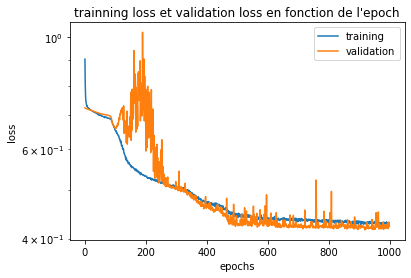

36631/36631 [==============================] - 41s 1ms/step - loss: 0.4330 - accuracy: 0.8197
Evaluation du modèle:  [0.43295007944107056, 0.8197134733200073]


In [175]:
plt.figure()                    
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.title('trainning loss et validation loss en fonction de l\'epoch')
plt.legend()
plt.show()

ev = combined_model.evaluate(primes10000_prop1_dec[:,1:], primes10000_prop1_dec[:,0])
print('Evaluation du modèle: ', ev)

### Histogramme de la probabilitée de nombres premier 

On distingue clairement 3 zones interessante dans cet histogramme, la premier entre 0,3 et 0,4, la seconde entre 0,50 et 0,65 et enfin la troisieme vers 0,75

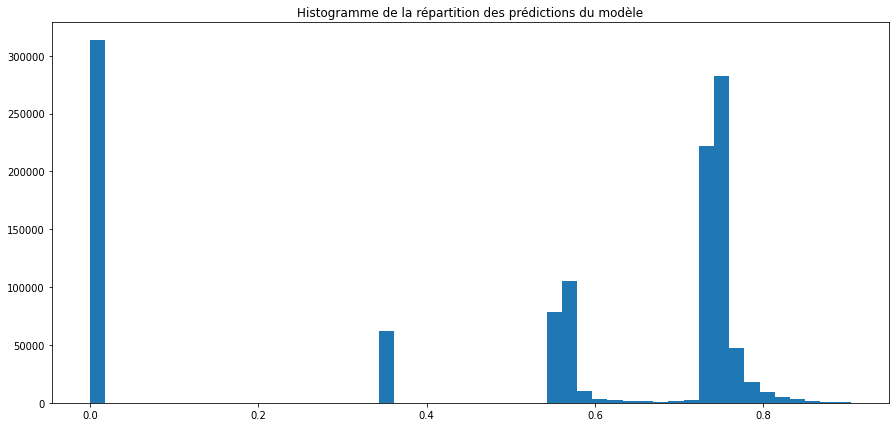

In [153]:
pred = combined_model.predict(primes10000_prop1_dec[:,1:])
fig = plt.subplots(1, 1, figsize=(15, 7))
_ = plt.hist(pred.reshape(len(pred),), bins=50)
plt.title('Histogramme de la répartition des prédictions du modèle')
plt.show()

In [157]:
n=100000

pred = combined_model.predict(primes10000_prop1_dec[:n,1:]) # on fait des predictions avec le modele

#############################

test = conv_pnums(0, n) # on recupere les index 

X_pred = (pred < 0.3)*1 
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P inférieur à 0,3')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')

X_pred = (pred > 0.3)*1 
X_pred = (pred < 0.4)*1
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P entre 0,3 et 0,4')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')


X_pred = (pred > 0.5)*1 
X_pred = (pred < 0.65)*1
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P entre 0,55 et 0,65')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')


X_pred = (pred > 0.7)*1 
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P superieur a 0,7')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')

predictions pour P inférieur à 0,3
nombres paires dans les prédictions:  0.7992274979516991
nombres correctement prédits:  0.0
taille de la liste:  25631


predictions pour P entre 0,3 et 0,4
nombres paires dans les prédictions:  0.8329166531380889
nombres correctement prédits:  0.0
taille de la liste:  30799


predictions pour P entre 0,55 et 0,65
nombres paires dans les prédictions:  0.5317565606732723
nombres correctement prédits:  0.27219020770283153
taille de la liste:  48242


predictions pour P superieur a 0,7
nombres paires dans les prédictions:  0.0
nombres correctement prédits:  0.7532475097570921
taille de la liste:  51501




# Modèle pour le dataset en base binaire

On commence par créer un dataset en base binaire composé par tous les nombres premiers plus petits que 100000 et des multiples avec un rapport égale à 1 pour éviter les problèmes de surapprentissage pour les multiples. 

In [11]:
train = add_random_multiples(primes_array,0,100000,1)
train_binaire = numbers_to_digits(train,30,2)

Après on va utiliser le modèle suivant qui est ce qui a marché le mieux pendant les essais.

In [12]:
model_binaire = tf.keras.Sequential([
    kl.Dense(50, kernel_regularizer=regularizers.l2(0.0001),
                 activation='tanh', input_dim=30),
    kl.Dropout(0.5),
    kl.Dense(1,activation='sigmoid')
])
Adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_binaire.compile(optimizer=Adam_optimizer, 
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
history = model_binaire.fit(train_binaire[:,1:], train_binaire[:,0],
          batch_size=32,        
          epochs=200,  
          validation_split=0.3,
          verbose=2)

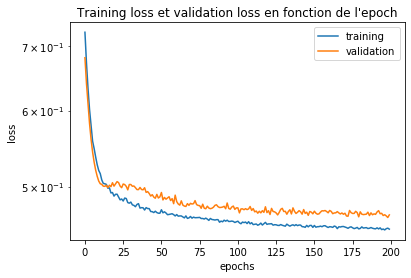

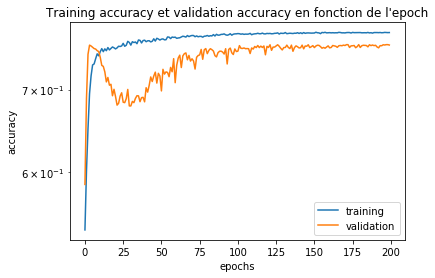

In [15]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training loss et validation loss en fonction de l\'epoch')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.yscale('log')
plt.title('Training accuracy et validation accuracy en fonction de l\'epoch')
plt.legend()
plt.show()

On obtient bien une descente de la valeur du loss et une croissance pour la valeur accuracy, mais il y a un saut abrupt pendant l'entraînement qu'on a pas su le résoudre.

Finalement, on a evalué le modèle avec des valeurs dehors du dataset d'entraînement, plus précisément dans l'intervalle 1e5 et 1e6. On a essayé d'evaluer le modèle avec un dataset qui avait seulment des nombres premiers du intervalle et dans un deuxième cas avec des multiples avec une proportion égale à 1 avec les nombres premiers. On a trouvé des résultats bizarres alors on a fait le test suivant avec différent proportions.

In [18]:
valmin = 100000
valmax = 1000000
prop = 0
test_ = add_random_multiples(primes_array,valmin,valmax,0)
test_binaire = numbers_to_digits(test_,30,2)
dim = len(test_)
prop_max = (valmax-valmin)//dim
prop_array = np.arange(prop_max)
acc_array = np.zeros(prop_max)
for i in prop_array:
    test_ = add_random_multiples(primes_array,valmin,valmax,i)
    test_binaire = numbers_to_digits(test_,30,2)
    acc_array[i] = model_binaire.evaluate(test_binaire[:,1:], test_binaire[:,0],verbose=1)[1]

27994/27994 [==============================] - 49s 2ms/step - loss: 0.4774 - accuracy: 0.5830


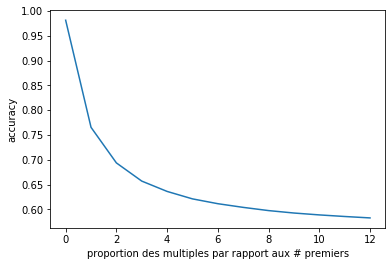

In [19]:
plt.plot(prop_array,acc_array)
plt.xlabel('proportion des multiples par rapport aux # premiers')
plt.ylabel('accuracy')
plt.show()

Comme on peut voir pour une proportion égale à 0 (dataset composé seulement de nombres premiers), on obtient une accuracy de presque 100%, mais selon on ajoute de multiples ça descend à jusqu'à 58%. Donc presque pour la moitié des multiples le modèle prédit que c'est un nombre premier.

27994/27994 [==============================] - 21s 742us/step


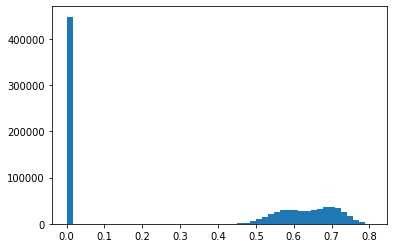

In [21]:
pred_binaire = model_binaire.predict(test_binaire[:,1:],verbose=1)
plt.hist(pred_binaire, bins=50)
plt.show()

Finalement, on confirme nos soupçons avec ce histograme. On attendait plus de 800 000 multiples mais on a un peu plus de 400 000.

# Résultats

### Prédictions
Ces résultats sont donc cohérent avec ce que l'on attendait, plus la probabilité donné est grande et plus il y a de chance que ca soit effectivement un nombres premier et inversement quand la probabilité est faible. 
On retrouve d'ailleurs approximativement la proportion de nombre premiers/multiples du dataset.

Le réseau est capable de comprendre que les nombres paires ne sont jamais des nombres premiers et il arrive à séparer les nombres premiers des nombres impaires avec précision de *82%*

### Base binaire

Lors que nous avons testé le réseau avec la base binaire nous n'avons pas constaté d'amélioration significative dans la qualité des prédictions, en entrainnant le réseau avec la base binaire nous trouvons un précision de *77*% ce qui est un peu moins qu'avec la base décimale mais qui reste toutefois très correct.

## Conclusions

En conclusion, ce réseau de neuronnes est bien capable de prédire des nombres premiers.

Nous avons vu qu'il est capable de séparer correctement les nombres premiers des multiples et  que, même si il ne permet pas de savoir à 100% si un nombre donné est premier ou non, il permet néanmoins de voir rapidement la proportion de nombres premiers dans un intervalle donnée avec une erreur minime.
Cette méthode étant beaucoup plus rapide que de calculer directement chaque nombres potentielement premier. 

# Prespectives

À cause de la contrainte de temps pour ce projet nous n'avons malheureusement pas pu essayer toutes piste possible pour améliorer ce réseau.

Une chose qui aurait pu être intéressante à faire aurait été de voir la distribution des nombres prédit correctement pour pousser l'analyse plus loin, de faire des analyse plus poussé des distributions afin de détecter de potentiel faille dans cette méthode.
On aurais aussi pu essayer d'autre architecture de réseau (tel qu'un réseau convolutif par exemple) ou d'optimiser l'architecture que nous avons utiliser pour gagner en performance/précision.